In [ ]:
# Download tensoflow models garden
!git clone --depth 1 -b v2.12.0 https://github.com/tensorflow/models.git

# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

In [ ]:
!pip install tensorflow_text

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as tf_hub
import tensorflow_text as tf_text
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
#GPU info
!nvidia-smi

Sat May 20 08:44:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", tf_hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.12.0
Eager mode:  True
Hub version:  0.13.0
GPU is available


Dataset link: https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip

In [4]:
URL = "https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip"

fname = os.path.join(os.getcwd(), "quora_dataset.csv.zip")

data_file = tf.keras.utils.get_file(fname = fname, origin = URL)

57602533/57602533 [==============================] - 55s 1us/step


In [5]:
from zipfile import ZipFile
from tqdm import tqdm
# Extract zip
with ZipFile(fname, "r") as zip:
  zip.printdir()
  files_list = zip.namelist()
  print("Extracting files")
  for file in tqdm(iterable = files_list, total = len(files_list)):
    zip.extract("train.csv", os.path.join(os.getcwd(), "quora_dataset"))

File Name                                             Modified             Size
train.csv                                      2019-12-11 04:05:42    124206772
Extracting files


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


In [6]:
data = pd.read_csv("quora_dataset/train.csv")
data.sample(10)

,qid,question_text,target
1281156,fb157e0a95a5f909ff6a,Which is the best PC strategy game?,0
1292716,fd5cc1a3e687f15d38c8,Which is the best SUV under good mileage?,0
797641,9c4c4e0fbf73990088f3,A girl responds with me normally even after hu...,0
282824,375f7398f26b0631ec8d,What is the age of JESUS on the first day of t...,0
928491,b5f5e07065c8fcf3032c,Why does the media strongly favor left wing po...,1
1201149,eb67eb44dce264fa406b,What will happen if you play loud nasheed musi...,0
742526,916e6b0f89529fde3584,If you don't want to catch up with an old frie...,0
1220573,ef38e389dd1f10ec7d48,How do I avoid paying extra VAT while shopping...,0
541129,6a050280bdcb86aba056,Why do girls that dress like sluts get upset w...,1
222185,2b772918d151ccbfa702,"Why has religious competition in Europe, espec...",0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [8]:
# Check for missing values
data.isna().sum()

qid              0
question_text    0
target           0
dtype: int64

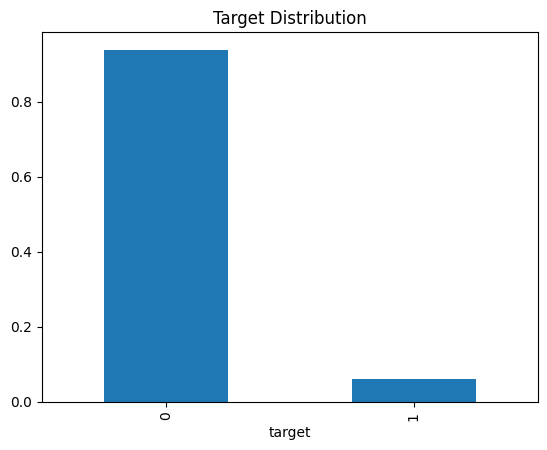

In [9]:
# Distribution of target
data["target"].value_counts(normalize=True).plot(kind = "bar", title = "Target Distribution")
plt.show();

* We have a skewed target distribution.
* We will perform a stratified train test split to maintain the distribution of target in both train and validation split

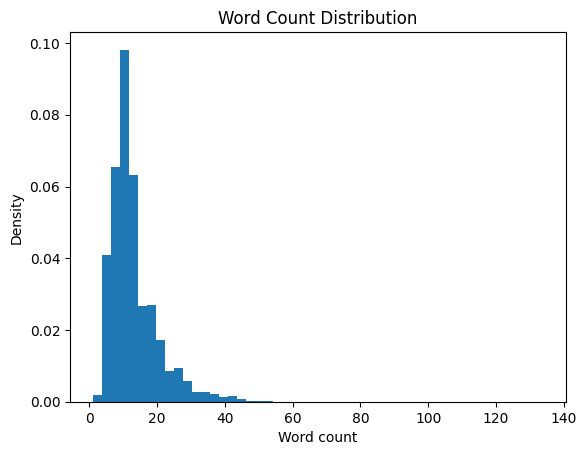

In [10]:
data["text_word_count"] = data["question_text"].str.split().apply(len)
plt.hist(data["text_word_count"], bins=50, density=True)
plt.xlabel("Word count")
plt.ylabel("Density")
plt.title("Word Count Distribution")
plt.show();

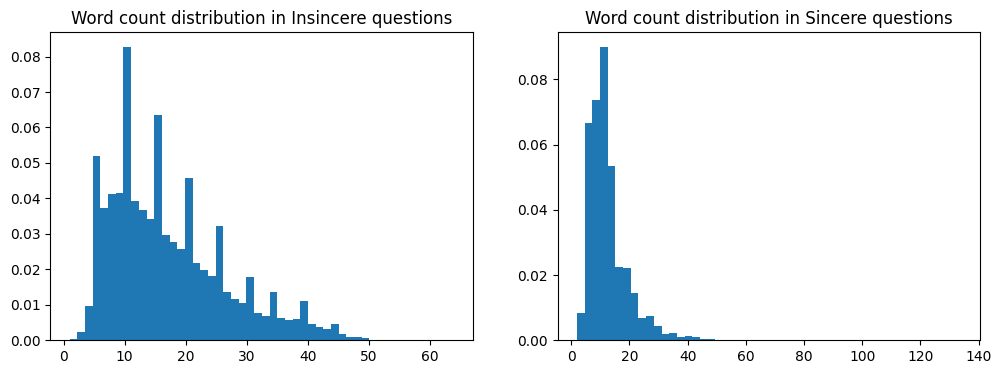

In [11]:
fig, [ax1,ax2] = plt.subplots(1,2,figsize = (12,4))
ax1.hist(data[data["target"]==1]["text_word_count"], bins=50, density=True)
ax2.hist(data[data["target"]==0]["text_word_count"], bins=50, density=True)
ax1.set(title = "Word count distribution in Insincere questions")
ax2.set(title = "Word count distribution in Sincere questions")
plt.show();

### Train Test split

* We will work with around 10k data points for training and 1k data points for validation as training on the entire data will take hours on Colab GPU

In [12]:
# Stratified train test split
df_train, remaining = train_test_split(data, train_size = 0.0075, stratify = data["target"])

In [13]:
df_val, _ = train_test_split(remaining, train_size = 0.00075, stratify = remaining["target"])

In [14]:
print("Shape of training data = ", df_train.shape)
print("Shape of validation data = ", df_val.shape)

Shape of training data =  (9795, 4)
Shape of validation data =  (972, 4)


In [15]:
# Distribution of target in training and validation sets
print("Target distribution in training split:")
print(df_train["target"].value_counts(normalize = True))
print("\nTarget distribution in validation split:")
print(df_val["target"].value_counts(normalize = True))

Target distribution in training split:
target
0    0.938132
1    0.061868
Name: proportion, dtype: float64

Target distribution in validation split:
target
0    0.938272
1    0.061728
Name: proportion, dtype: float64


## Input Pipeline

* BERT is expensive to train and has slower inference time because of its large size and 109 million params. Another cause is the input/output bottleneck due to writing data backforth to CPU and GPU.

* Tensorflow's tf.data API help us design flexible and efficient input pipelines and address above issues.

In [16]:
# Get the text and target from the dataframe
train_text = tf.convert_to_tensor(df_train["question_text"].values.reshape((df_train.shape[0],-1)))
train_target = tf.convert_to_tensor(df_train["target"].values.reshape((df_train.shape[0],-1)))
val_text = tf.convert_to_tensor(df_val["question_text"].values.reshape((df_val.shape[0],-1)))
val_target = tf.convert_to_tensor(df_val["target"].values.reshape((df_val.shape[0],-1)))

In [17]:
type(train_text)

tensorflow.python.framework.ops.EagerTensor

In [18]:
print("Above tensors are placed on:")
print("train_text:", train_text.device)
print("train_target:", train_target.device)
print("val_text:", train_text.device)
print("val_target:", train_text.device)

Above tensors are placed on:
train_text: /job:localhost/replica:0/task:0/device:GPU:0
train_target: /job:localhost/replica:0/task:0/device:GPU:0
val_text: /job:localhost/replica:0/task:0/device:GPU:0
val_target: /job:localhost/replica:0/task:0/device:GPU:0


* To avoid GPU overhead we will create the dataset and apply all transformations on CPU

In [19]:
# List all the available CPUs
tf.config.list_physical_devices("CPU")

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [48]:
# If the data is already in memory we can use the from_tensor_slices() function to create the dataset
with tf.device('/cpu:0'):
  train_dataset = tf.data.Dataset.from_tensor_slices((train_text, tf.squeeze(train_target)))
  val_dataset = tf.data.Dataset.from_tensor_slices((val_text, tf.squeeze(val_target)))

In [21]:
with tf.device('/cpu:0'):
  iterator = train_dataset.as_numpy_iterator() # returns a numpy array as iterator
  for _ in range(3):
    text, label = iterator.next()
    print("Text =", text)
    print("Label =", label)

# The following piece of code will return a tf.tensor
# for text, label in train_dataset.take(1):
#   print("Text = ", text)
#   print("Label = ", label)

Text = [b'What are the best paid fields in science except engineering and medical?']
Label = 0
Text = [b'How does one compute the period of any pseudo-random number generator?']
Label = 0
Text = [b'Can the OBS, SC and ST candidates compete for the general seats even after opting for their own reservation?']
Label = 0


## Text preprocessing

In [63]:
# Import the preprocessing modules from the downloaded "models" repo
import sys
sys.path.append("models")
from models.official.nlp.data import classifier_data_lib
from models.official.nlp.tools import tokenization
from models.official.nlp import optimization

Each data point of the dataset is composed of the question text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer


In [23]:
labels = [0, 1]
BATCH_SIZE = 32
max_seq_len = 128 #maximum length of each sequence

In [24]:
# Get BERT layer
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2

bert_layer = tf_hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True)

#### Create Lookup table for tokenization

In [25]:
# Get the vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
# Check if the loaded bert model cased or uncased
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [26]:
print("Vocab_file path:", vocab_file.decode("utf-8"))
print("uncased model:", do_lower_case)

Vocab_file path: /tmp/tfhub_modules/d760773f85f64fc84ae0b47310f7cfe3bcec4868/assets/vocab.txt
uncased model: True


In [27]:
# Load the vocab file that corresponds to the pretrained BERT
def load_vocab(vocab_file):
  "Load the vocabulary into a list"
  vocab = []
  with tf.io.gfile.GFile(vocab_file, "r") as reader:
    while True:
      token = reader.readline()
      if not token: break
      token = token.strip()
      vocab.append(token)
  return vocab

# Use BERT vocab to create a word to index lookup table
def create_vocab_table(vocab, num_oov_buckets=1):
  """Create a lookup table for a vocabulary"""
  vocab_values = tf.range(tf.size(vocab, out_type=tf.int64), dtype=tf.int64)
  init = tf.lookup.KeyValueTensorInitializer(keys=vocab, values=vocab_values, key_dtype=tf.string, value_dtype=tf.int64)
  vocab_table = tf.lookup.StaticVocabularyTable(init, num_oov_buckets, lookup_key_dtype=tf.string)
  return vocab_table

# Use BERT vocab to create a index to word lookup table
def create_index2token(vocab):
  # Create a lookup table for a index to token
  vocab_values = tf.range(tf.size(vocab, out_type=tf.int64), dtype=tf.int64)
  init = tf.lookup.KeyValueTensorInitializer(keys=vocab_values, values=vocab)
  return tf.lookup.StaticHashTable(initializer=init, default_value=tf.constant('unk'), name="index2word")

In [28]:
# Load the vocabulary into a list
vocab_list = load_vocab(vocab_file.decode("utf-8"))
# Create a vocabulary lookup table from BERT vocab
vocab_lookup_table = create_vocab_table(vocab_list)
# A lookup table mapping integer indices to words
index2token_lookup = create_index2token(vocab_list)

In [29]:
# Check the integer indices of the following tokens in the vocabilary lookup table
vocab_lookup_table.lookup(tf.constant(['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]']))

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([  0, 100, 101, 102, 103])>

In [30]:
# Check out the token corresponding to an index in the int2token looup table
index2token_lookup.lookup(tf.constant([0], dtype='int64'))

<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[PAD]'], dtype=object)>

#### Preprocess the text

In [31]:
# Instantiate a bert tokenizer 
tokenizer = tf_text.BertTokenizer(
    vocab_lookup_table,
    token_out_type = tf.int64,
    lower_case = do_lower_case
)

In [32]:
# Test the tokenizer
# Here we get the index of token as we had specified 
#token_out_type as int (if we specify string then we get words)
tokens = tokenizer.tokenize(["Hi, How are you doing ?"])
tokens

<tf.RaggedTensor [[[7632],
  [1010],
  [2129],
  [2024],
  [2017],
  [2725],
  [1029]]]>

In [33]:
# flatten the output ragged tensors and search in tokens looup table
index2token_lookup.lookup(tokens.merge_dims(-2,-1)[:, :])

<tf.RaggedTensor [[b'hi', b',', b'how', b'are', b'you', b'doing', b'?']]>

In [34]:
#Lookup for the BERT token IDs for padding and start/end of sentence.
PAD_ID = vocab_lookup_table.lookup(tf.constant('[PAD]')) # padding token
CLS_ID = vocab_lookup_table.lookup(tf.constant('[CLS]')) # class token
SEP_ID = vocab_lookup_table.lookup(tf.constant('[SEP]')) # sequence separator token

In [35]:
# function to use in dataset.map()
def preprocess(x,y):
  return preprocess_bert_input(x, max_seq_len, tokenizer), y

# Function to convert text into input format accepted by BERT
def preprocess_bert_input(text, max_seq_len, tokenizer):
  # input token ids
  input_word_ids = tokenize_text(text, max_seq_len, tokenizer)
  input_ids = tf.cast(input_word_ids, tf.int32)
  # input mask
  input_mask = tf.cast(input_ids > 0, tf.int32)
  input_mask = tf.reshape(input_mask, [-1, max_seq_len])
  # Token type ids
  zeros_dims = tf.stack(tf.shape(input_mask))
  input_type_ids = tf.fill(zeros_dims, 0)
  input_type_ids = tf.cast(input_type_ids, tf.int32)
  
  input = dict(input_word_ids = tf.reshape(input_word_ids, [-1]),
               input_mask = tf.reshape(input_mask, [-1]),
               input_type_ids = tf.reshape(input_type_ids, [-1]))
  # Return the ids
  #return (tf.squeeze(input_ids), tf.squeeze(input_masks), tf.squeeze(input_type_ids))
  return input

# Function to tokenize a text
def tokenize_text(text, max_seq_len, tokenizer):
    '''
    Args:
    tokenizer: A bert tokenizer object
    text: A tensor of rank >=1
    max_seq_len: int
    '''
    # Convert text into tokens
    # text.BertTokenizer returns a RaggedTensor with shape [batch, num_tokens, num_wordpieces]
    tokens = tokenizer.tokenize(text)
    # Flatten the resulting ragged tensor
    tokens = tokens.merge_dims(-2,-1)
    # Truncate sequences greater than max_seq_len-2(for CLS and SEP tokens)
    tokens = tokens[:, :max_seq_len-2]
    # Add CLS and SEP token ids
    start_tokens = tf.fill([tf.shape(text)[0], 1], CLS_ID)
    end_tokens = tf.fill([tf.shape(text)[0], 1], SEP_ID)
    tokens = tf.concat([start_tokens, tokens, end_tokens], axis=1)
    # Pad shorter sequences with PAD token id
    tokens = tokens.to_tensor(default_value = PAD_ID)
    pad = max_seq_len - tf.shape(tokens)[1]
    tokens = tf.pad(tokens, [[0,0], [0, pad]], constant_values = PAD_ID)
    # Reshape the word tokens ids to fit the output data structure of TFT
    tokens = tf.reshape(tokens, [-1, max_seq_len])
    return tokens
  

def test_func():
  tex = [data["question_text"].iloc[5]]
  tex = tf.convert_to_tensor(tex, dtype = tf.string)
  lab = np.array(data["target"].iloc[5])
  lab = tf.convert_to_tensor(lab, dtype = tf.int64)
  #return tokenize_text(tex, 40, tokenizer)
  #return preprocess_bert_input(tex, 40, tokenizer)
  return preprocess(tex, lab)

test_func()

({'input_word_ids': <tf.Tensor: shape=(128,), dtype=int64, numpy=
  array([  101,  2003, 14474,  3254,  3352, 24363,  1010,  4830,  7507,
          2226,  2030, 29461, 16558, 19839,  2050,  2005, 21524,  1029,
           102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0

In [64]:
# Here is another way of getting the inputs in above form using imoprted classifier_data_lib

tknzr = tokenization.FullTokenizer(vocab_file, do_lower_case=do_lower_case)

# Define a python function to convert into feature
def to_feature(text, label, label_list=labels, max_seq_len=max_seq_len, tokenizer=tknzr):
  # Construct a single input example
  example = classifier_data_lib.InputExample(guid=None, 
                                             text_a=text.numpy(), 
                                             text_b=None, 
                                             label=label.numpy())
  # Get the features of a single example
  feature = classifier_data_lib.convert_single_example(0, example, labels, max_seq_len, tknzr)
  # return the components of input feature
  return feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id

# Convert the function to be able to use in graph mode
def to_feature_map(text, label):
  input_word_ids, input_mask, input_type_ids, label_id = tf.py_function(to_feature, 
                                                                   inp = [text, label], 
                                                                   Tout = [tf.int32, tf.int32, tf.int32, tf.int32])
  input_word_ids.set_shape([max_seq_len])
  input_mask.set_shape([max_seq_len])
  input_type_ids.set_shape([max_seq_len])
  label_id.set_shape([])

  input_feature = {
      "input_word_ids": input_word_ids,
      "input_mask": input_mask,
      "input_type_ids": input_type_ids
  }

  return input_feature, label_id

In [67]:
# Construct a single input example
example = classifier_data_lib.InputExample(guid=None, 
                                            text_a=tex.numpy(), 
                                            text_b=None, 
                                            label=lab.numpy())
# Get the features of a single example
feature = classifier_data_lib.convert_single_example(0, example, labels, max_seq_len, tknzr)
# return the components of input feature

In [62]:
type(feature.input_ids)

list

In [56]:
# Test the above function
tex = tf.convert_to_tensor(data["question_text"].iloc[5])
lab = tf.convert_to_tensor(data["target"].iloc[5])
# call the function
feat = to_feature(tex, lab, label_list=labels, max_seq_len=40, tokenizer=tknzr)
print(feat[0], feat[1], feat[2], feat[3],sep="\n")
print()

inp_feat, lab_id = to_feature_map(tex, lab)
print(inp_feat)
print(lab)

[101, 2003, 14474, 3254, 3352, 24363, 1010, 4830, 7507, 2226, 2030, 29461, 16558, 19839, 2050, 2005, 21524, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0

{'input_word_ids': <tf.Tensor: shape=(128,), dtype=int32, numpy=
array([  101,  2003, 14474,  3254,  3352, 24363,  1010,  4830,  7507,
        2226,  2030, 29461, 16558, 19839,  2050,  2005, 21524,  1029,
         102,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     

In [38]:
# Refer: https://stackoverflow.com/questions/63557955/tensorflow-2-3-attributeerror-tensor-object-has-no-attribute-numpy
try:
  train_dataset.map(lambda x,y: to_feature(x,y))
except Exception as e:
  print("Following error occured\n",e)

Following error occured
 in user code:

    File "<ipython-input-38-18fde11bd8a1>", line 3, in None  *
        lambda x,y: to_feature(x,y)
    File "<ipython-input-36-19f1a956de52>", line 8, in to_feature  *
        example = classifier_data_lib.InputExample(guid=None,

    AttributeError: 'Tensor' object has no attribute 'numpy'



In [49]:
# prepare the tf.data.Dataset
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = (train_dataset.map(to_feature_map, num_parallel_calls = AUTOTUNE)
                              .batch(32)
                              .prefetch(AUTOTUNE))

val_dataset = (val_dataset.map(to_feature_map, num_parallel_calls = AUTOTUNE)
                          .batch(32)
                          .prefetch(AUTOTUNE))

In [50]:
train_dataset.element_spec

({'input_word_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

# Build the model

In [51]:
# Building the model
def build_model():
  encoder_inputs = dict(
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32),
    input_mask = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32),
    input_type_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32),
    )

  enocder_outputs = bert_layer(encoder_inputs)

  drop = tf.keras.layers.Dropout(0.4)(enocder_outputs["pooled_output"])
  output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(drop)

  model = tf.keras.Model(inputs=encoder_inputs, outputs=output)
  return model

In [52]:
# Fine tune the model

model = build_model()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'sequence_output':  109482241   ['input_2[0][0]',                
                                 (None, 128, 768),                'input_3[0][0]',            

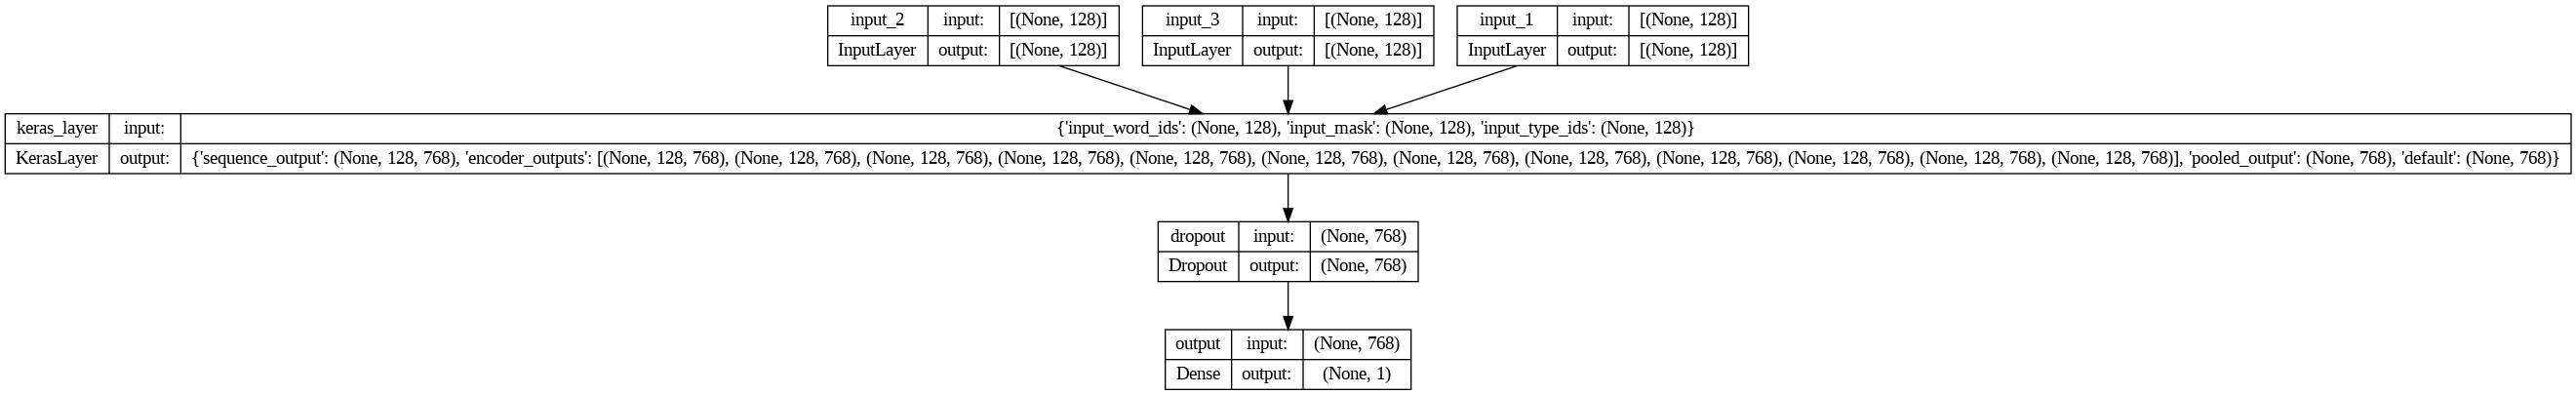

In [53]:
# plot the model
tf.keras.utils.plot_model(model, show_shapes=True)

In [71]:
# Optimizer to update the weights
optim = tf.keras.optimizers.Adam(learning_rate = 0.001)
# Loss calculation
loss = tf.keras.losses.BinaryCrossentropy()
# metrics
metric1 = tf.keras.metrics.Recall()
metric2 = tf.keras.metrics.FalseNegatives()
# Compile the model
model.compile(optimizer = optim,
              loss = loss,
              metrics = [metric1, metric2])

In [70]:
model.fit(train_dataset, epochs = 5, validation_data=val_dataset)

Epoch 1/5


InvalidArgumentError: ignored

In [46]:
tf.keras.backend.clear_session()